In [1]:
from utilities.grover_state_preparation import *
from utilities.auxiliaries import *
from config import *
     

import numpy as np
from scipy.stats import beta, chisquare, entropy, wasserstein_distance
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from qiskit import transpile
from qiskit.visualization import circuit_drawer

In [2]:
alpha = 2
beta_ = 2
a = 0
b = 1
idx_thetas_to_optimize = [0]
     

p_i_set = beta.pdf(np.linspace(a, b, 2**m), alpha, beta_) # changed len(2**m-1) to len(2**m)
p_i_set /= p_i_set.sum()
     

thetas_to_optimize = np.array(generate_parameters(len(idx_thetas_to_optimize), k=2))
thetas = get_grover_angles(p_i_set, m)


Initial thetas:
[np.float64(1.5707963267948966), np.float64(3.141592653589793), np.float64(0.0)]

Starting circuit:


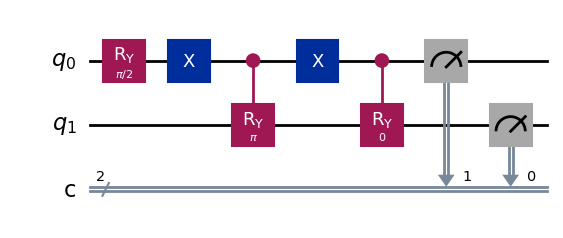

In [3]:
initial_qc = state_expansion(m, thetas)
print("\nInitial thetas:")
print(thetas)
print("\nStarting circuit:")
circuit_drawer(initial_qc, output='mpl')

In [4]:
loss = []
extra_angles = []
samples_all = []
loss_history = []
best_loss = float('inf')
best_thetas = None
best_distribution = None
for run in range(runs):
    result = minimize(objective_function, thetas_to_optimize,
                      args=(idx_thetas_to_optimize, thetas, p_i_set, shots),
                      method=optimizer_type, options={"disp": False, "maxiter": max_iterations})
    current_loss = result.fun
    thetas_to_optimize = result.x
    loss_history.append(current_loss)
    if current_loss < best_loss:
        best_loss = current_loss
        best_thetas = np.array(thetas.copy())
        best_thetas[idx_thetas_to_optimize] = thetas_to_optimize

In [5]:
final_qc  = state_expansion(m, best_thetas)
t_qc = transpile(final_qc , backend=backend)
job = backend.run(t_qc, shots=shots)
counts = job.result().get_counts(final_qc )
samples = np.array([counts.get(state, 0) for state in all_states], dtype=float)
samples /= samples.sum()
emd = wasserstein_distance(samples, p_i_set)
kl_div = entropy(samples, p_i_set)
print(f"KL Divergence: {kl_div:.6f}")
print(f"Earth Mover's Distance: {emd}")

KL Divergence: 0.000618
Earth Mover's Distance: 0.0087890625


In [6]:
print(len(p_i_set))

4


In [7]:
print(len(samples))

4



Final thetas:
[4.71030141 3.14159265 0.        ]

Final circuit:


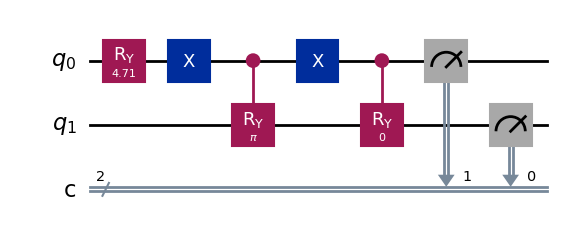

In [8]:
print("\nFinal thetas:")
print(best_thetas)
final_qc = state_expansion(m, best_thetas)
print("\nFinal circuit:")
circuit_drawer(final_qc, output='mpl')

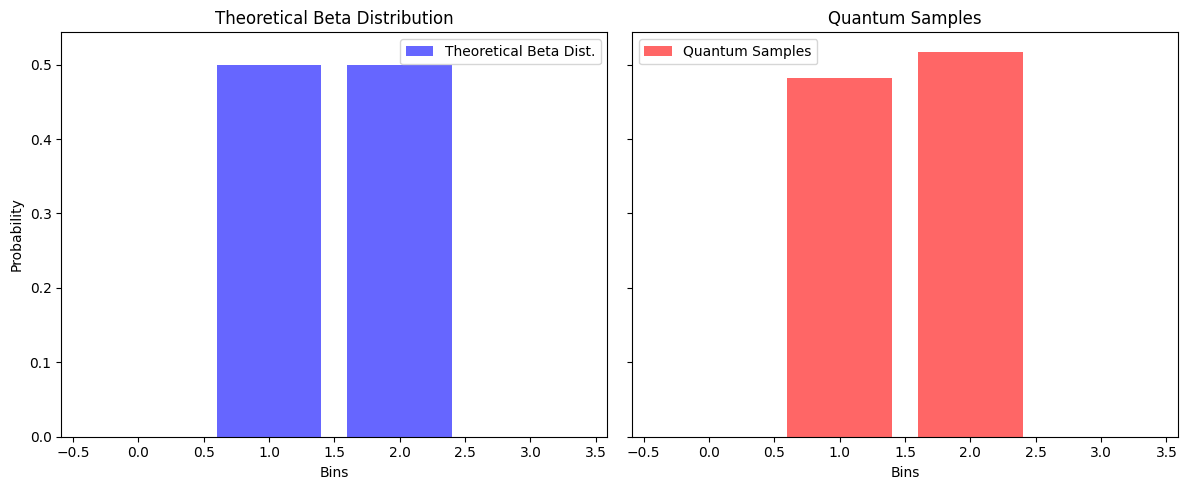

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

axes[0].bar(range(len(p_i_set)), p_i_set, alpha=0.6, label='Theoretical Beta Dist.', color='blue')
axes[0].set_xlabel("Bins")
axes[0].set_ylabel("Probability")
axes[0].legend()
axes[0].set_title("Theoretical Beta Distribution")

axes[1].bar(range(len(samples)), samples, alpha=0.6, label='Quantum Samples', color='red')
axes[1].set_xlabel("Bins")
axes[1].legend()
axes[1].set_title("Quantum Samples")

plt.tight_layout()
plt.show()


Best loss: 0.0033341929320049755


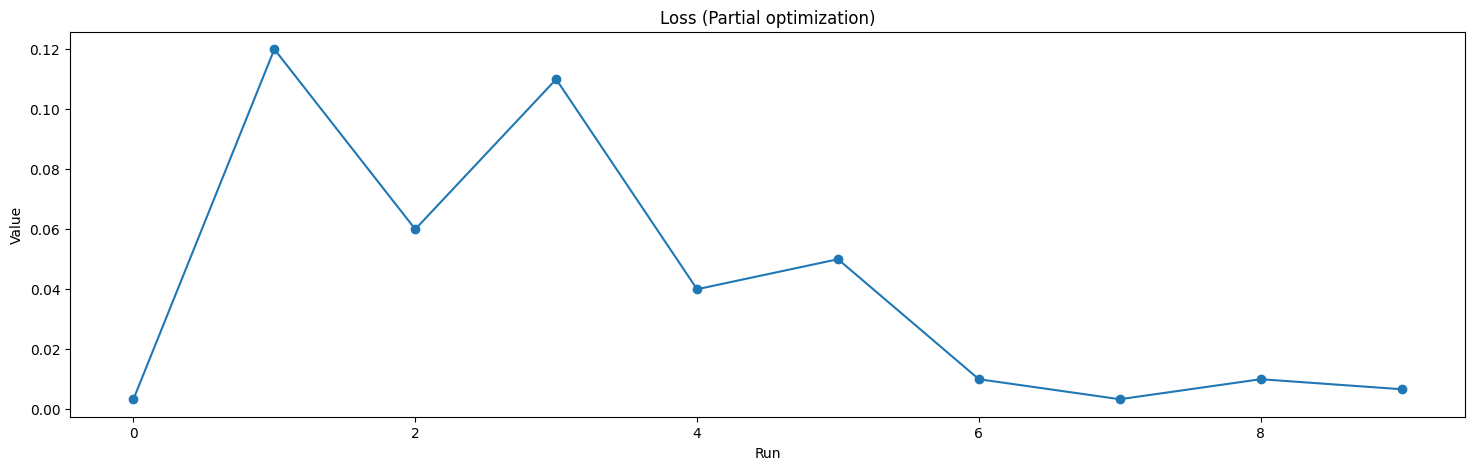

In [11]:
print("Best loss:", best_loss)

plt.figure(figsize=(18, 5))
plt.plot(loss_history, marker='o', linestyle='-')
plt.xlabel("Run")
plt.ylabel("Value")
plt.title("Loss (Partial optimization)")
plt.show()